## Sagnac Frequency - Phase Jump Detection

...

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


config['tbeg'] = UTCDateTime("2024-05-25 00:00")
config['tend'] = UTCDateTime("2024-05-26 00:00")

# config['tbeg'] = UTCDateTime("2024-05-31 00:00")
# config['tend'] = UTCDateTime("2024-06-01 00:00")

flim1, flim2 = 447.726, 447.745

config['time_offset'] = 60 # seconds

config['t1'] = config['tbeg']-config['time_offset']
config['t2'] = config['tend']+config['time_offset']

# specify sampling rate of rotation rate data
config['sampling_rate'] = 20 # Hz

# compute expected number of samples
config['Nexpected'] = int((config['t2'] - config['t1']) * config['sampling_rate'])

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_sds_out'] = archive_path+"temp_archive/"

config['path_to_inventory'] =  data_path+"stationxml_ringlaser/dataless/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load backscatter data

In [4]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Load rotation rate data

In [5]:
romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

In [6]:
st0 = Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['t1'], config['t2'])

# remove sensitivity
st0 = st0.remove_sensitivity(romy_inv)

print(st0)

# check if merging is required
if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

print(st0)

# remove trend
st0 = st0.detrend("linear")

# check if data has same length
for tr in st0:
    Nreal = len(tr.data)
    if Nreal != config['Nexpected']:
        tr.data = tr.data[:config['Nexpected']]
        # print(f" -> adjust length: {tr.stats.station}.{tr.stats.channel}:  {Nreal} -> {config['Nexpected']}")

# st0 = __rotate_romy_ZUV_ZNE(st0, romy_inv, keep_z=True)

# st0 = st0.trim(config['tbeg'], config['tend'])

st0

6 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-05-24T23:59:00.009799Z - 2024-05-26T00:01:00.009799Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJU   | 2024-05-24T23:58:59.989000Z - 2024-05-25T06:37:56.339000Z | 20.0 Hz, 478728 samples
BW.ROMY..BJU   | 2024-05-25T06:38:00.138201Z - 2024-05-25T19:12:59.638201Z | 20.0 Hz, 905991 samples
BW.ROMY..BJU   | 2024-05-25T19:13:01.562799Z - 2024-05-26T00:01:00.012799Z | 20.0 Hz, 345570 samples
BW.ROMY..BJV   | 2024-05-24T23:59:00.019599Z - 2024-05-25T09:48:44.369599Z | 20.0 Hz, 707688 samples
BW.ROMY..BJV   | 2024-05-25T09:48:45.644199Z - 2024-05-26T00:00:59.994199Z | 20.0 Hz, 1022688 samples
 -> merging required!
3 Trace(s) in Stream:
BW.ROMY..BJU   | 2024-05-24T23:58:59.989000Z - 2024-05-26T00:00:59.989000Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJV   | 2024-05-24T23:59:00.019599Z - 2024-05-26T00:00:59.969599Z | 20.0 Hz, 1730400 samples
BW.ROMY.10.BJZ | 2024-05-24T23:59:00.009799Z - 2024-05-26T00:01:00.009799Z | 20.0 Hz, 1730401 samples


3 Trace(s) in Stream:
BW.ROMY..BJU   | 2024-05-24T23:58:59.989000Z - 2024-05-26T00:00:59.939000Z | 20.0 Hz, 1730400 samples
BW.ROMY..BJV   | 2024-05-24T23:59:00.019599Z - 2024-05-26T00:00:59.969599Z | 20.0 Hz, 1730400 samples
BW.ROMY.10.BJZ | 2024-05-24T23:59:00.009799Z - 2024-05-26T00:00:59.959799Z | 20.0 Hz, 1730400 samples

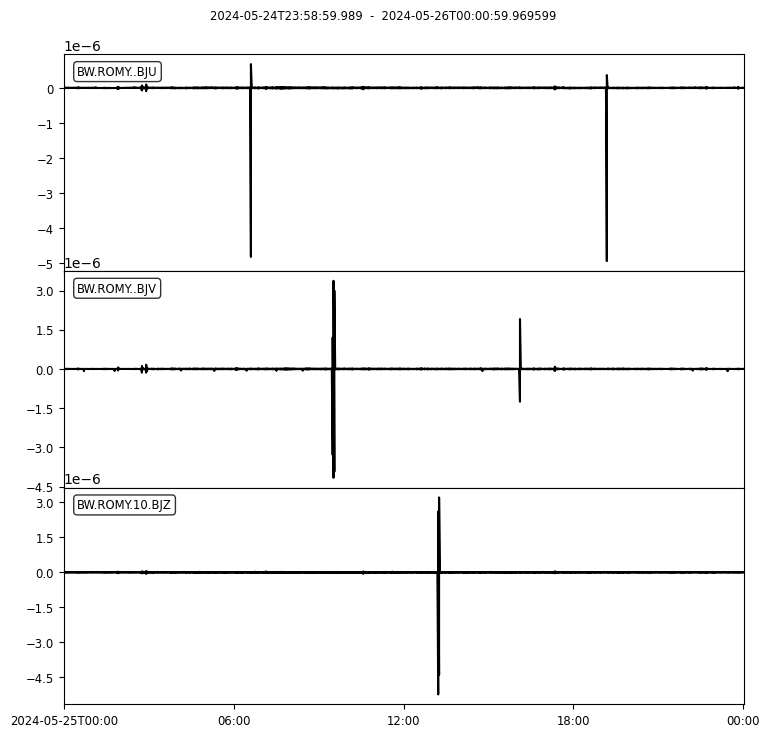

In [7]:
st0.plot(equal_scale=False);

In [ ]:
def get_phase_jumps(arr, times, LT, ST, amp_threshold, plot=True):

    import numpy as np
    from scipy.signal import hilbert
    from functions.smoothing import __smooth

    def sta_lta_detect(_data, threshold_upper, threshold_lower=None):

        N = len(_data)

        detection = np.ones(N)
        ratio = np.zeros(N)

        triggered = False
        for n in range(N):

            if n < LT:
                continue

            # compupte LTA, STA and ratio
            LTA = np.nanmean(abs(_data[n-int(LT):n]))
            STA = np.nanmean(abs(_data[n-int(ST):n]))
            ratio[n] = abs(STA-LTA)

            if triggered and ratio[n] > threshold_lower and threshold_lower is not None:
                detection[n] = 0
                continue
            else:
                triggered = False

            if ratio[n] > threshold_upper and threshold_lower is not None:
                detection[n] = np.nan
                detection[n-1] = np.nan
                triggered = True

        # detect events based on threshold
        for n, a in enumerate(ratio):
            if a > threshold_upper:
                detection[n] = np.nan
                detection[n-1] = np.nan

        return detection, ratio


    amp_threshold_lower = 0.5

    # dpha = __smooth(dpha, 10)

    # 1st derivative of amplitude
    damp = np.gradient(arr)

    # 2nd derivative
    # damp = np.gradient(damp)

    # absolute values
    damp = abs(damp)

    detect, amp_ratio = sta_lta_detect(damp, amp_threshold)

    if plot:

        import matplotlib.pyplot as plt

        Nrow, Ncol = 2, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].plot(times, arr)
        ax[0].plot(times, arr*np.array(detect))

        ax[1].plot(times, amp_ratio, "k")
        ax[1].axhline(amp_threshold, color="darkred", alpha=0.5, ls="--")
        ax[1].set_ylim(0, 3*amp_threshold)

        for _k in range(Nrow):
            ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        for _n, d in enumerate(detect):
            if np.isnan(d):
                ax[0].axvline(times[_n], 0, np.nanmax(arr)*2, color="grey", alpha=0.2, zorder=1)
                ax[1].axvline(times[_n], 0, 10, color="grey", alpha=0.2, zorder=1)

        plt.show();

    # change detections to one and everything else to zero
    detect2 = abs(np.nan_to_num(detect, 0) - 1)

    return np.array(amp_ratio), np.array(detect2)

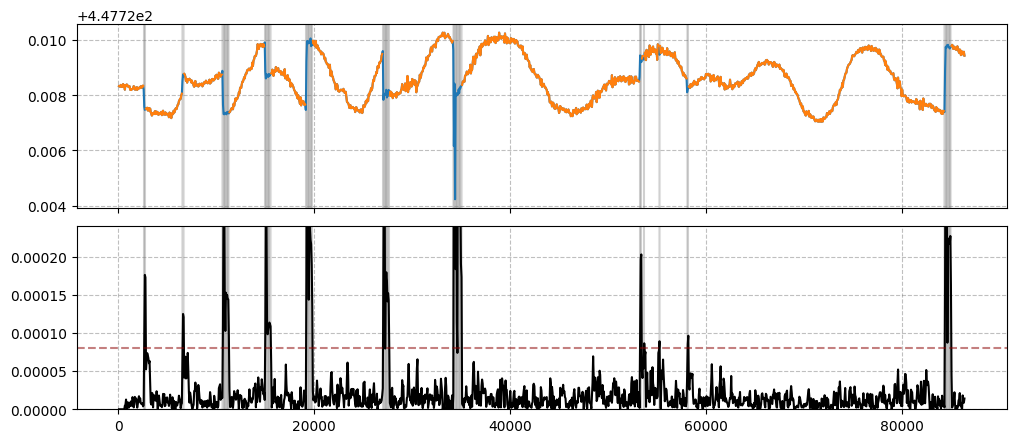

In [205]:
# x1 = 1000
# x2 = x1+6000

# data0 = np.array(bs.fj_fs[x1:x2])
# time0 = np.array(bs.time_sec[x1:x2])

data0 = np.array(bs.fj_fs)
time0 = np.array(bs.time_sec)

ratio, detect = get_phase_jumps(data0, time0, 10, 3, amp_threshold=0.00008)

In [206]:
# n = st0.select(component="U")[0].data
# ntime = st0.select(component="U")[0].times()

# # ratio, detect = get_phase_jumps(n, ntime, 10, 3, amp_threshold=0.0001)

In [207]:
mask1 = np.where(detect == 1, bs.time1, np.nan)
mask2 = np.where(detect == 1, bs.time2, np.nan)

mask_df = DataFrame()
mask_df['mask1'] = mask1
mask_df['mask2'] = mask2

mask_df = mask_df.dropna()

mask1 = np.array(mask_df.mask1)
mask2 = np.array(mask_df.mask2)

In [208]:
def __get_trace(seed):

    from obspy import Trace
    from numpy import zeros

    net, sta, loc, cha = seed.split('.')

    trr = Trace()
    trr.stats.starttime = config['t1']
    trr.data = zeros(config['Nexpected'])
    trr.stats.network = net
    trr.stats.station = sta
    trr.stats.location = loc
    trr.stats.channel = cha
    trr.stats.sampling_rate = config['sampling_rate']

    return trr

In [209]:
def __mlti_intervals_to_zero(dat, times, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where, full, array

    dat = array(dat)

    mask = full((len(times)), 0, dtype=int)

    idx = 0
    for nn, tt in enumerate(times):

        if idx >= len(mlti_t1):
            continue
        else:
            t1, t2 = (mlti_t1[idx]-t_offset_sec), (mlti_t2[idx]+t_offset_sec)

        if tt >= t1:
            mask[nn] = 1
        if tt > t2:
            idx += 1

    dat = where(mask == 1, 1, dat)

    return dat

In [210]:
import obspy as obs

tr_maskV = __get_trace("BW.ROMY.30.MLT")

tr_maskV.data = __mlti_intervals_to_zero(tr_maskV.data,
                                         tr_maskV.times(reftime=config['t1'], type="utcdatetime"),
                                         mask1,
                                         mask2,
                                         t_offset_sec=60,
                                         )

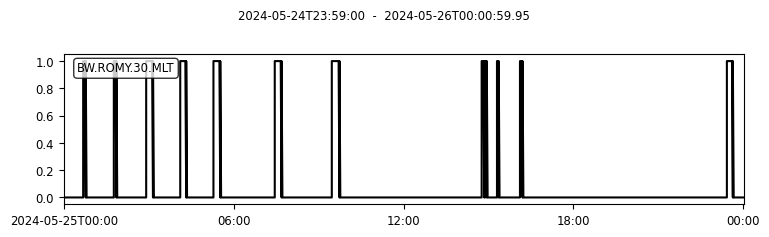

In [211]:
tr_maskV.plot();

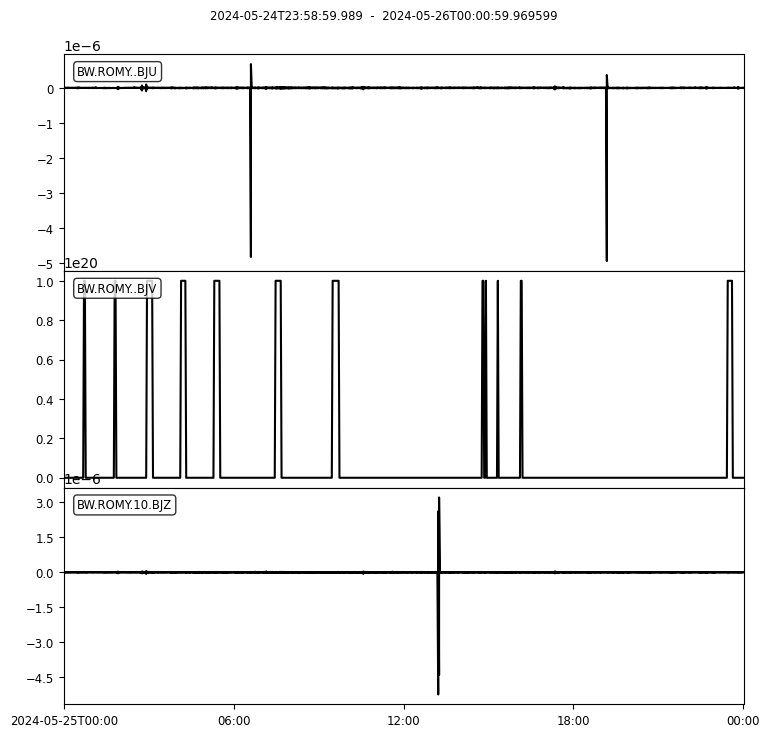

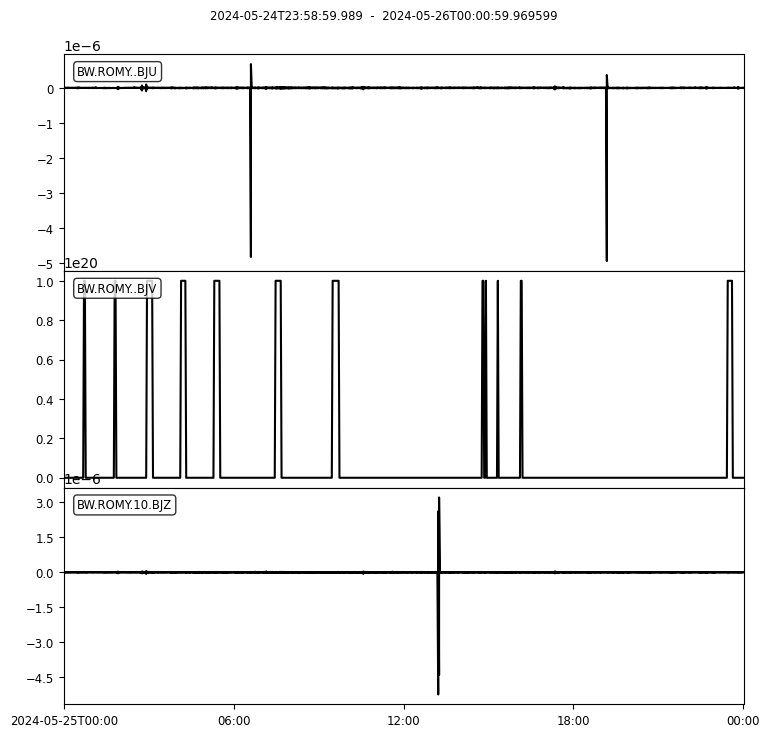

In [212]:
import numpy.ma as ma

st0.select(component="V")[0].data = ma.masked_array(st0.select(component="V")[0].data,
                                                    mask=tr_maskV.data,
                                                    fill_value=np.nan
                                                   )

st0.plot(equal_scale=False)

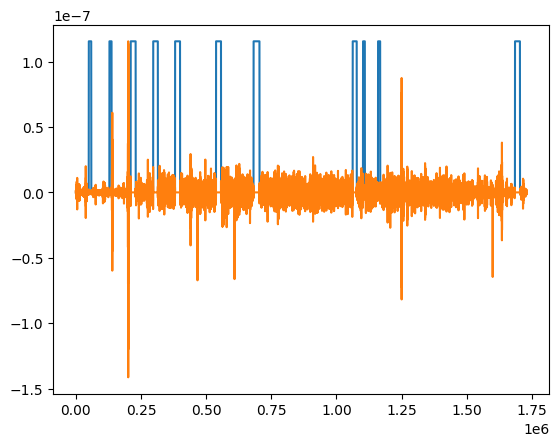

In [113]:
plt.plot(tr_maskV.data*max(v*maskx))
plt.plot(v*maskx)


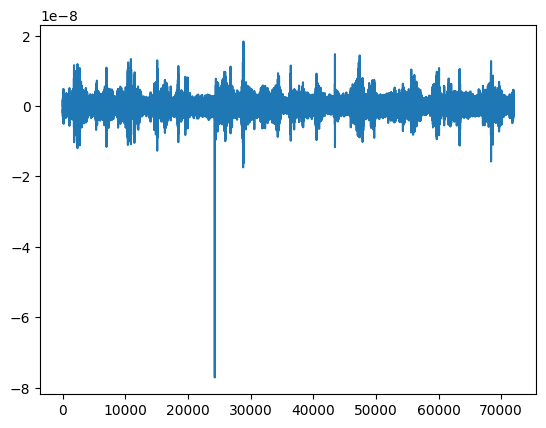

In [280]:
x1 = int(5*3600*20)
x2 = x1+int(1*3600*20)

V = st0.select(component="V")[0].data[x1:x2]
Vtime = st0.select(component="V")[0].times()[x1:x2]

plt.plot(V)

# test, tt, yy, ii = __get_phase_jumps(V, Vtime, fraction_of_pi=2, plot=True)


In [179]:
x1 = int(5*3600*20)
x2 = x1+int(2*3600*20)

V = st0.select(component="V")[0].data[x1:x2]
Vtime = st0.select(component="V")[0].times()[x1:x2]


In [212]:
N = int(np.ceil(np.sqrt(len(V))))

Ndiff = N**2 - len(V)

V_pad = np.append(V, np.ones(Ndiff)*V[-1])

Vimg = V_pad.reshape(N, N)

# aVimg = abs(Vimg)

In [213]:
import numpy as np


def masking(img, n=3, method='mean', stats=[None, None]):
    '''
    Search for outlayer pixels with a value lower/larger
    than the mean/median/other ± n × std
    '''
    if method.lower() == 'average':
        avg, std = stats[0], stats[1]
    elif method == 'mean':
        avg, std = np.nanmean(img), np.nanstd(img)
    elif method == 'median':
        avg, std = np.nanmedian(img), np.nanstd(img)
    return (img < (avg - n * std)) | (img > (avg + n * std))

# def mean(img, n=3, size=1):
#     '''
#     Despike the image with a mean mask ± n × std
#     '''
#     return fill(img, masking(img, n, 'mean'), 'mean', size)

# def average(img, n=3, size=1, stats=(None, None)):
#     '''
#     Despike the image with a average mask ± n × std
#     '''
#     return fill(img, masking(img, n, 'average', stats), 'mean', size)

# def median(img, n=3, size=1):
#     '''
#     Despike the image with a median mask ± n × std
#     '''
#     return fill(img, masking(img, n, 'median'), 'median', size)


def box(A, i, j, size=1, nan=False):
    '''
    Extract the box (subarray) around (i,j) value inside
    a box of size `size` and replace the centrale
    value by NaN if necessary [option].
    '''
    if not isinstance(A, (list, np.ndarray)):
        raise TypeError(
            'The input must be an array. {} provided'.format(type(A)))

    ny, nx = A.shape
    if i < 0:
        raise ValueError('Line index `i` must be ≥ 0')
    if j < 0:
        raise ValueError('Column index `j` must be ≥ 0')
    if i >= nx:
        raise ValueError('Line index `i` must be < {}'.format(nx))
    if j >= ny:
        raise ValueError('Column index `j` must be < {}'.format(ny))

    if not isinstance(size, int):
        raise TypeError('Size must be an int')
    if size < 1:
        raise ValueError('The box size must be ≥ 1')

    if nan:
        # The change of type is required to store a NaN
        A = np.array(A, dtype=np.double)
        A[j, i] = np.nan

    l = i - size if i - size > 0 else 0
    r = i + size if i + size < nx else nx
    t = j - size if j - size > 0 else 0
    b = j + size if j + size < ny else ny

    return A[t:b+1, l:r+1]

def mean(A):
    return np.nanmean(A), np.nanstd(A)

def median(A):
    return np.nanmedian(A), np.nanstd(A)

def spikes(img, method='mean', size=2, n=3):
    '''
    Search spikes in the image using a moving box
    of size `size` using `method` method with ± n × std
    '''
    if method.lower() == 'mean':
        mask = mean
    elif method.lower() == 'median':
        mask = median
    elif method.lower() == 'average':
        mask = None
        m, s = np.median(img), np.nanstd(img)
        if s < 1e-8:
            s = 1e-8
    else:
        raise ValueError("The masking method must be '[mean|median]")

    # s = np.nanpercentile(abs(img), 98)

    ny, nx = img.shape
    _spikes = np.zeros((ny, nx))
    for i in range(nx):
        for j in range(ny):
            m, s = mask(box(img, i, j, size, nan=True))
            if s < 1e-8:
                s = 1e-8
            if img[j, i] < m - n * s or img[j, i] > m + n * s:
                _spikes[j, i] = 1

    return _spikes == 1

def fill(img, mask, method='mean', size=1):
    '''
    Fill the masked pixels with the mean value of
    surrounding neighboors inside a box of size `size`
    '''
    if img.shape != mask.shape:
        raise ValueError('Image and outlayers mask must have the same dimentsion: {} vs. {}'.format(
            img.shape, mask.shape
        ))

    if method.lower() == 'mean':
        f = np.nanmean
    elif method.lower() == 'median':
        f = np.nanmedian
    else:
        raise ValueError("The filling method must be '[mean|median]")

    A = np.copy(img)
    ny, nx = A.shape
    x, y = np.meshgrid(range(nx), range(ny))

    for x, y in zip(x[mask], y[mask]):
        A[y, x] = f(box(A, x, y, size=size, nan=True))
    return A


def clean(img, mask='mean', size=2, n=3, fill_method='median', fill_size=1):
    '''
    Clean image from spikes with the `fill_method` method with surrounding
    neighboors inside a box of size `fill_size`.
    '''
    aimg = abs(img)
    return fill(img, spikes(aimg, mask, size, n), fill_method, fill_size)


In [214]:
# import despike

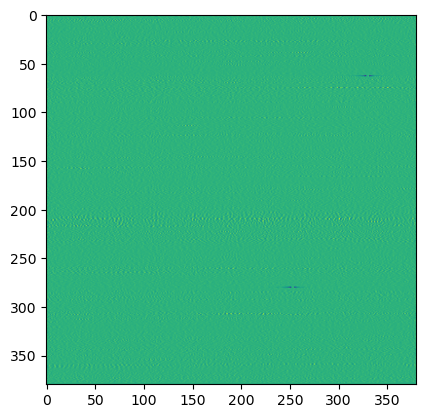

In [224]:
Vimg_clean = clean(Vimg, mask='median', size=5, n=5, fill_method='median', fill_size=1)

plt.imshow(Vimg_clean)

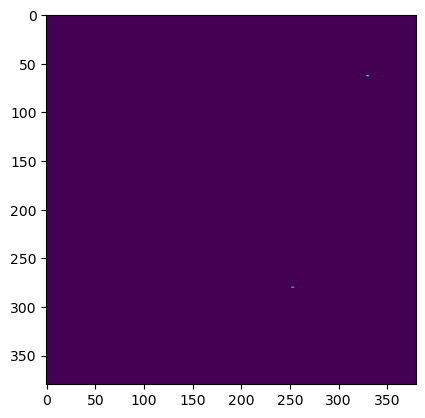

In [225]:
plt.imshow(Vimg_clean - Vimg)

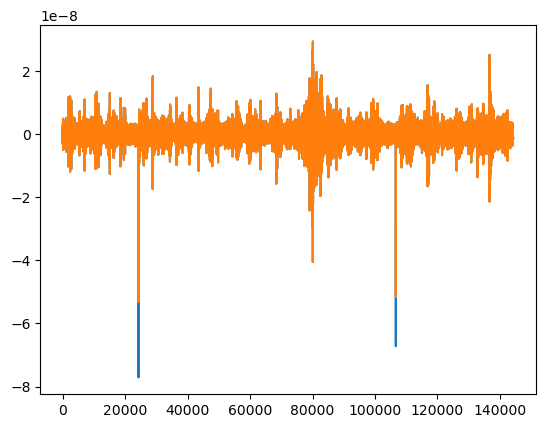

In [226]:
V_filt = Vimg_clean.reshape(1, len(V)+Ndiff)[:N][0]

plt.plot(V)
plt.plot(V_filt)

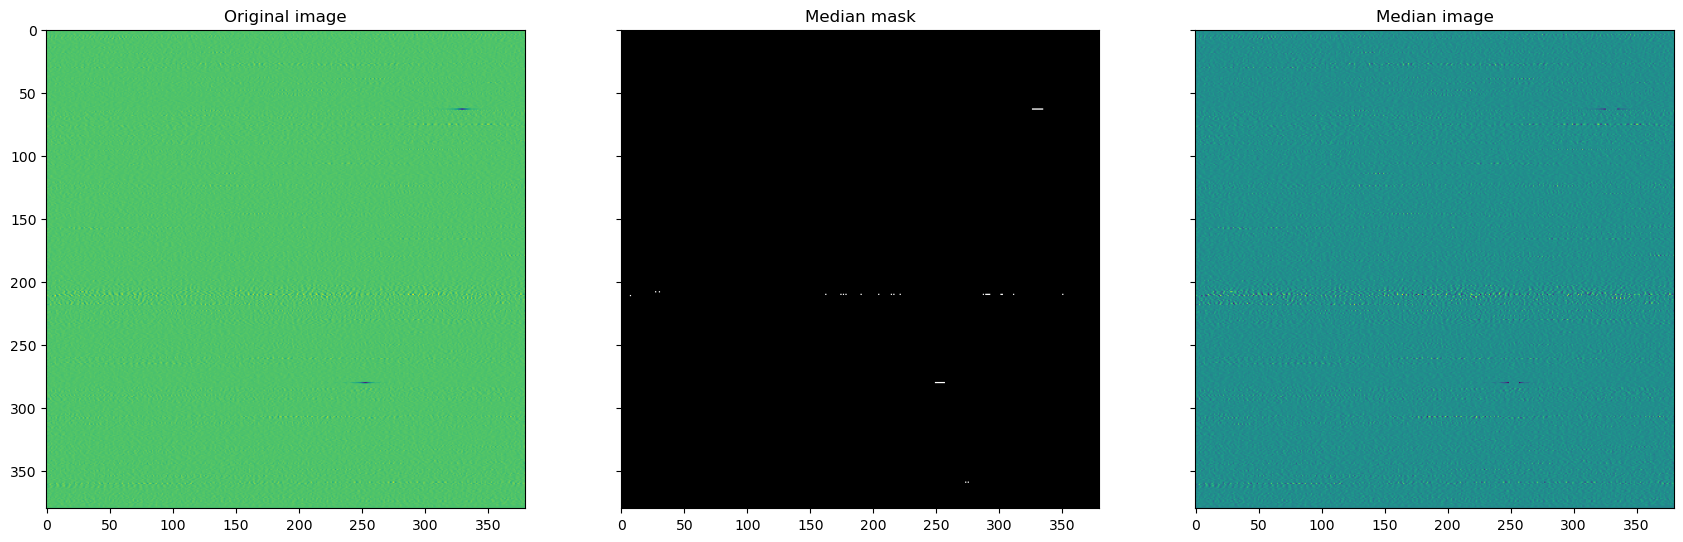

In [199]:
# Median filtering
from despike.median import mask, median

median_mask = mask(Vimg, 10)
median_img = median(Vimg, 10)


Vimg_new = Vimg - Vimg*median_mask

f, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(21, 7))

# cmap1=plt.get_cmap('viridis')

ax0.imshow(Vimg)
ax1.imshow(median_mask, cmap=plt.get_cmap('gray'))
ax2.imshow(Vimg_new)
ax0.set_title('Original image')
ax1.set_title('Median mask')
ax2.set_title('Median image')
plt.show()

In [104]:
V_filt = Vimg_clean.reshape(1, len(V)+Ndiff)[:N][0]

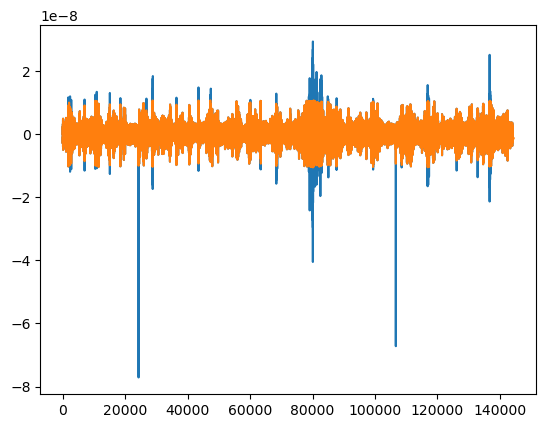

In [105]:
plt.plot(V)
plt.plot(V_filt)

### Compute Backscatter (again)

In [8]:
from functions.backscatter_correction import __backscatter_correction

In [9]:
# unwrap phases as one time series
# bs['fj_ph'] = np.unwrap(bs.fj_ph)
# bs['f1_ph'] = np.unwrap(bs.f1_ph)
# bs['f2_ph'] = np.unwrap(bs.f2_ph)

# use complete unwrapped phases
bs['fj_ph'] = np.unwrap(bs.fj_phw)
bs['f1_ph'] = np.unwrap(bs.f1_phw)
bs['f2_ph'] = np.unwrap(bs.f2_phw)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)


### Find phase jumps

In [213]:
def __get_phase_jumps(arr, time, fraction_of_pi=6, plot=True):

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.signal import hilbert

    data = arr.copy()

    # define threshold for phase jump identification
    threshold = np.pi/fraction_of_pi

    # remove mean of data to avoid jumps at start and end
    data -= np.nanmean(data)

    # avoid having to deal with nan values
    data = np.nan_to_num(data, nan=0)

    # compute Hilbert transform
    H = hilbert(data)

    # obtain angle of hilibert
    # pha = np.angle(H)
    pha = np.unwrap(np.angle(H))

    # derivative of angle
    dpha = np.gradient(pha, edge_order=1)

    # dpha /= np.real(H)
    # dpha /= max(abs(pha))
    # dpha /= sum((np.gradient(test)))

    # detect phase changes
    dpha_y = [_x if abs(_x) > threshold and abs(_x) < 3.14 else np.nan for _x in dpha]

    # detect phase indices
    dpha_idx = [list(dpha).index(_x) for _x in dpha if abs(_x) > threshold and abs(_x) < 3.14]

    # apply filter
    out = [np.nan if _i in dpha_idx else arr[_i] for _i in range(len(arr))]

    # checkup plot
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(15, 8))

        ax[0].plot(time, dpha)
        ax[0].scatter(time, dpha_y, color="tab:orange", s=10, zorder=2)
        ax[0].axhline(threshold, color="red", ls="--", alpha=0.5)
        ax[0].axhline(-threshold, color="red", ls="--", alpha=0.5)

        ax[1].plot(time, data)
        for line in time[dpha_idx]:
            ax[1].axvline(line, -1000, 1000, zorder=0, alpha=0.3, color="tab:orange")

        plt.show();

    return np.array(out), time[dpha_idx], np.array(dpha_y)[dpha_idx], np.array(dpha_idx)

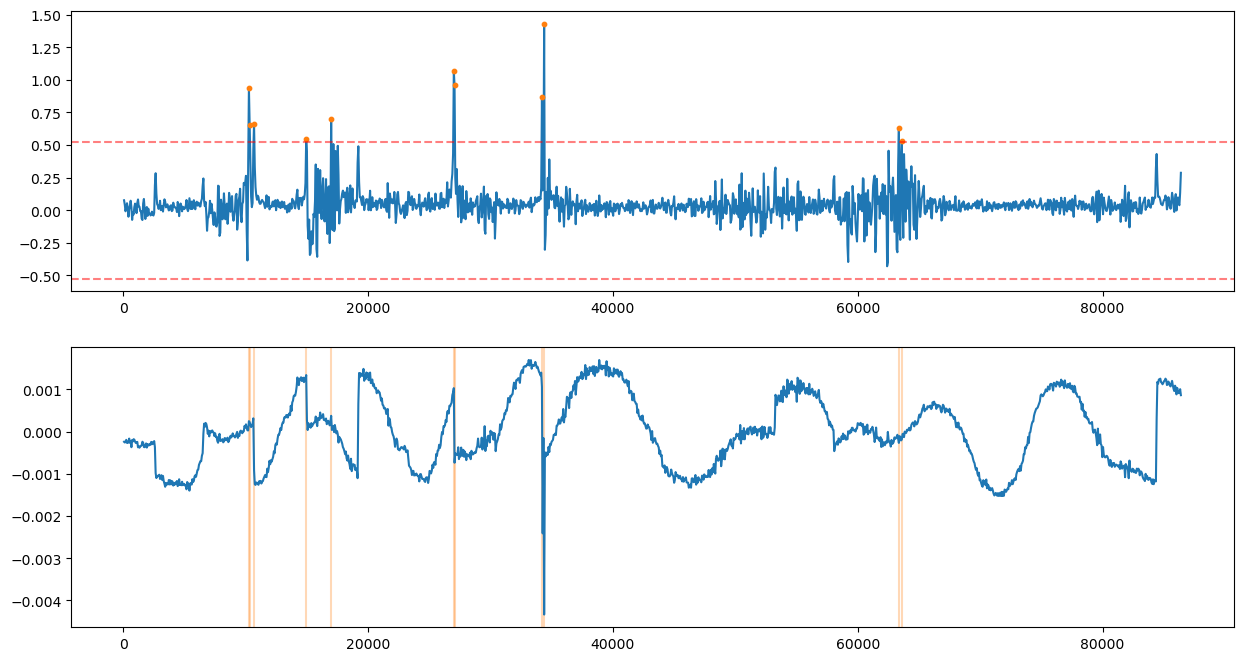

In [12]:
bs['fj_fs'], tt, yy, ii = __get_phase_jumps(bs.fj_fs, bs.time_sec, fraction_of_pi=6, plot=True)

In [13]:
_, tt1, yy1, ii1 = __get_phase_jumps(bs.fj_fs, bs.time_sec, fraction_of_pi=50, plot=False)

_, tt2, yy2, ii2 = __get_phase_jumps(bs.fj_bs, bs.time_sec, fraction_of_pi=50, plot=False)


/tmp/ipykernel_134082/767284436.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))


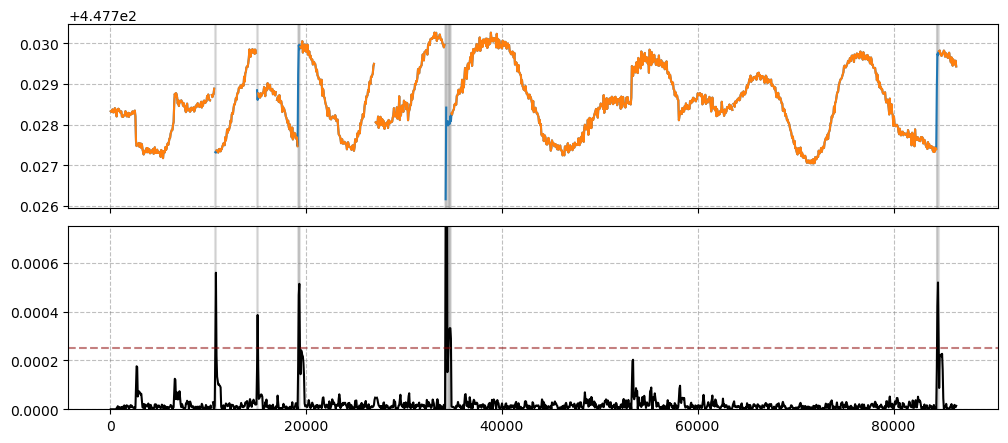

In [15]:
def get_phase_jumps(arr, times, LT, ST, amp_threshold, plot=True):

    import numpy as np
    from scipy.signal import hilbert
    from functions.smoothing import __smooth

    def sta_lta_detect(_data, threshold_upper, threshold_lower=None):

        N = len(_data)

        detection = np.ones(N)
        ratio = np.zeros(N)

        triggered = False
        for n in range(N):

            if n < LT:
                continue

            # compupte LTA, STA and ratio
            LTA = np.nanmean(abs(_data[n-int(LT):n]))
            STA = np.nanmean(abs(_data[n-int(ST):n]))
            ratio[n] = abs(STA-LTA)

            if triggered and ratio[n] > threshold_lower and threshold_lower is not None:
                detection[n] = 0
                continue
            else:
                triggered = False

            if ratio[n] > threshold_upper and threshold_lower is not None:
                detection[n] = np.nan
                detection[n-1] = np.nan
                triggered = True

        # detect events based on threshold
        for n, a in enumerate(ratio):
            if a > threshold_upper:
                detection[n] = np.nan
                detection[n-1] = np.nan

        return detection, ratio


    amp_threshold_lower = 0.5

    # dpha = __smooth(dpha, 10)

    # 1st derivative of amplitude
    damp = np.gradient(arr)

    # 2nd derivative
    # damp = np.gradient(damp)

    # absolute values
    damp = abs(damp)

    detect, amp_ratio = sta_lta_detect(damp, amp_threshold)

    if plot:

        import matplotlib.pyplot as plt

        Nrow, Ncol = 2, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].plot(times, arr)
        ax[0].plot(times, arr*np.array(detect))

        ax[1].plot(times, amp_ratio, "k")
        ax[1].axhline(amp_threshold, color="darkred", alpha=0.5, ls="--")
        ax[1].set_ylim(0, 3*amp_threshold)

        for _k in range(Nrow):
            ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        for _n, d in enumerate(detect):
            if np.isnan(d):
                ax[0].axvline(times[_n], 0, np.nanmax(arr)*2, color="grey", alpha=0.2, zorder=1)
                ax[1].axvline(times[_n], 0, 10, color="grey", alpha=0.2, zorder=1)

        plt.show();

    # change detections to one and everything else to zero
    detect2 = abs(np.nan_to_num(detect, 0) - 1)

    return np.array(amp_ratio), np.array(detect2)


x1 = 1000
x2 = x1+6000

# data0 = np.array(bs.fj_fs[x1:x2])
# time0 = np.array(bs.time_sec[x1:x2])

data0 = np.array(bs.fj_fs)
time0 = np.array(bs.time_sec)

ratio, detect = get_phase_jumps(data0, time0, 10, 3, amp_threshold=0.00025)


49440 49440


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

(array([  0., 537.,   6.,   5.,   4.,   3.,   1.,   1.,   1.,   2.,   3.,
          3.,   0.,   2.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,
          1.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   3.,   2.,   0.,
          0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,
          0.,   0.,   0.,   0.,   1.]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340., 2400., 2460., 2520., 2580., 2640.,
        2700., 2760., 2820., 2880., 2940., 3000., 3060., 3120., 3180.,
        3240., 3300., 3360., 3420., 3480., 3540., 3600.]),
 <BarContainer object of 60 artists>)

(0.5, 735.3142796882815)

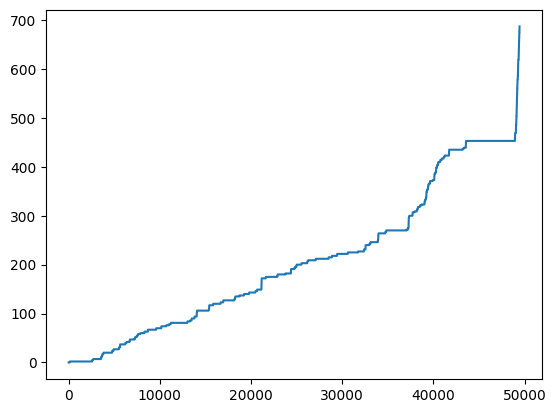

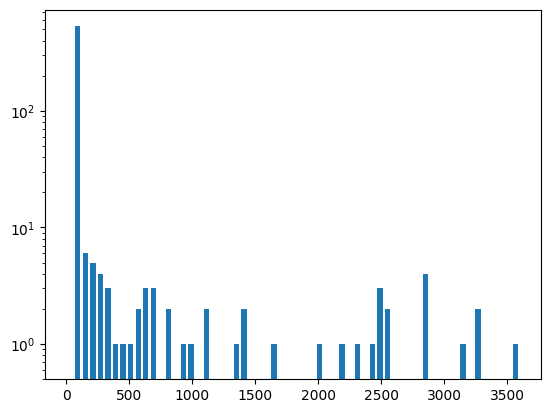

In [328]:
print(len(bs.fj_fs), len(detect))


mask = np.where(detect==1, 1, 0)

time_mask = time0 * detect

time_inter = time_mask[time_mask != 0]

inter = np.diff(time_inter)
inter[0] = inter[1]

plt.figure()
plt.plot(np.cumsum(detect))

NN = 3600
plt.figure()
plt.hist(inter, bins=int(NN/60), range=(0, NN), log=True, rwidth=0.7)
plt.ylim(bottom=0.5)

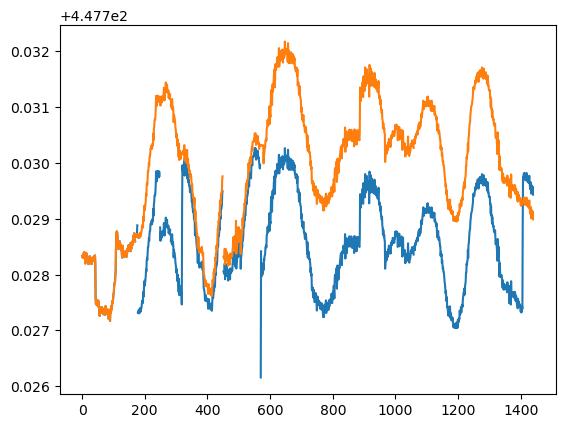

In [17]:
data = np.array(bs.fj_fs)

for _i in range(len(data)):

    if detect[_i] == 1:
        left = np.nanmean(data[_i-8:_i-3])
        right = np.nanmean(data[_i+3:_i+8])

        diff = left - right

        data[_i-3:_i] = left

        data[_i:] += diff


# plt.plot(bs.fj_fs[:-40000])
# plt.plot(data[:-40000])

plt.plot(bs.fj_fs)
plt.plot(data)

# plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [292]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [293]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [294]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [295]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [296]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

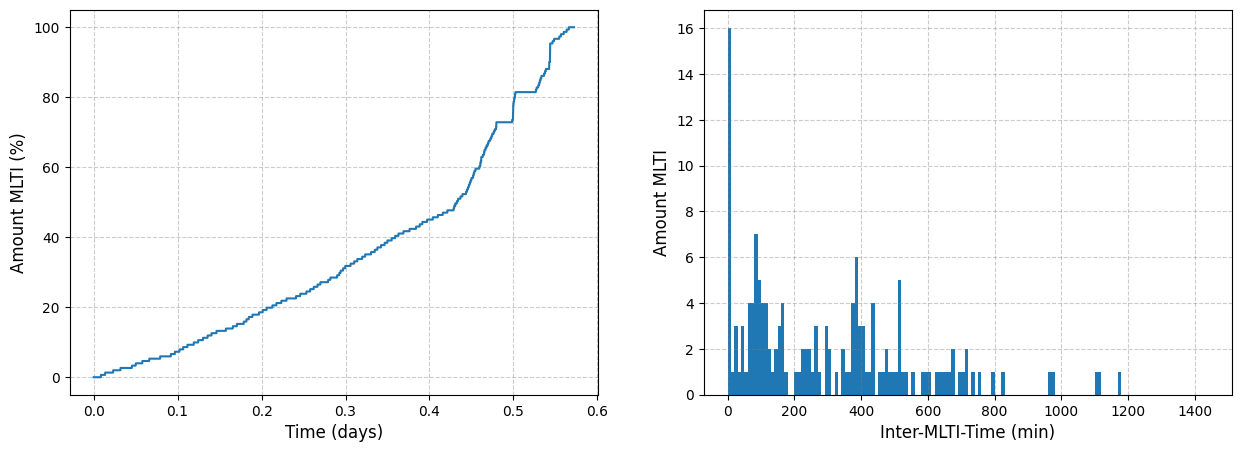

In [297]:
from functions.get_mlti_statistics import __get_mlti_statistics

mlti_cumsum, mlti_inter_sec = __get_mlti_statistics(mlti_t1, bs.time1, plot=True, ylog=False)

### Apply special filter sections

In [319]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [320]:
from functions.smoothing import __smooth

n_minutes = 60

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [321]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [322]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

In [323]:
bs

,index,time1,time2,fj_fs,fj_ac,fj_dc,fj_ph,fj_st,fj_phw,f1_fs,...,bscorrection,term,time_sec,fj_bs,fj_fs_nan,fj_bs_nan,fj_fs_inter,fj_bs_inter,fj_fs_smooth,fj_bs_smooth
0,0,2024-05-22T16:00:00.000000Z,2024-05-22T16:01:00.000000Z,447.732009,0.437290,0.413326,0.674936,0.002880,0.674936,447.733934,...,0.000889,0.999998,60.0,447.731119,447.732009,447.731119,447.732009,447.731119,NaN,NaN
1,1,2024-05-22T16:01:00.000000Z,2024-05-22T16:02:00.000000Z,447.732206,0.435066,0.413298,0.327300,0.003307,0.327300,447.731479,...,0.000872,0.999998,120.0,447.731334,447.732206,447.731334,447.732206,447.731334,NaN,NaN
2,2,2024-05-22T16:02:00.000000Z,2024-05-22T16:03:00.000000Z,447.732219,0.435419,0.413314,-0.128219,0.002920,-0.128219,447.732569,...,0.000858,0.999998,180.0,447.731360,447.732219,447.731360,447.732219,447.731360,NaN,NaN
3,3,2024-05-22T16:03:00.000000Z,2024-05-22T16:04:00.000000Z,447.732048,0.435024,0.413312,-0.580535,0.002817,-0.580535,447.732180,...,0.000855,0.999998,240.0,447.731193,447.732048,447.731193,447.732048,447.731193,NaN,NaN
4,4,2024-05-22T16:04:00.000000Z,2024-05-22T16:05:00.000000Z,447.732043,0.434762,0.413296,-1.042712,0.003099,-1.042712,447.732200,...,0.000851,0.999998,300.0,447.731191,447.732043,447.731191,447.732043,447.731191,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49435,55,2024-06-25T23:55:00.000000Z,2024-06-25T23:56:00.000000Z,NaN,0.000329,0.011951,-15218.428151,2.099027,-0.553337,447.602246,...,0.000007,1.000000,2966160.0,NaN,NaN,NaN,447.741225,447.741230,NaN,NaN
49436,56,2024-06-25T23:56:00.000000Z,2024-06-25T23:57:00.000000Z,NaN,0.000963,0.012391,-15218.059644,0.026223,-0.184830,447.646498,...,0.000016,1.000000,2966220.0,NaN,NaN,NaN,447.741225,447.741230,NaN,NaN
49437,57,2024-06-25T23:57:00.000000Z,2024-06-25T23:58:00.000000Z,NaN,0.001191,0.012406,-15217.463317,0.015288,0.411497,447.678835,...,0.000030,1.000000,2966280.0,NaN,NaN,NaN,447.741225,447.741230,NaN,NaN
49438,58,2024-06-25T23:58:00.000000Z,2024-06-25T23:59:00.000000Z,NaN,0.001116,0.012670,-15216.570314,0.018413,1.304500,447.650623,...,0.000026,1.000000,2966340.0,NaN,NaN,NaN,447.741225,447.741230,NaN,NaN


### Checkup Plot

/tmp/ipykernel_420350/1830721788.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


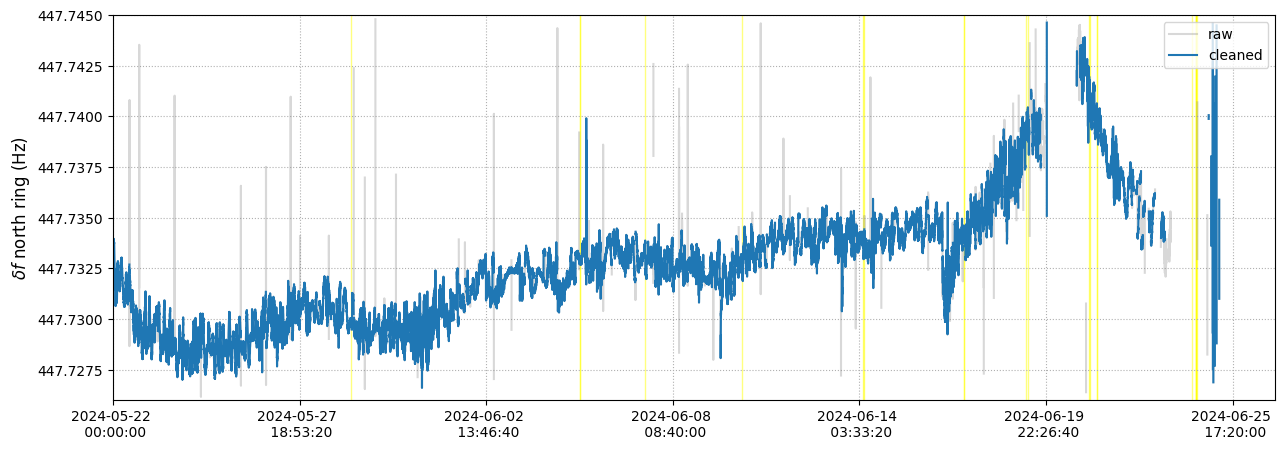

In [324]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring'}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


In [325]:
from functions.multitaper_psd import __multitaper_psd
from scipy.signal import detrend

bs['fj_bs_smooth_inter'] = __interpolate_nan(np.array(bs.fj_bs_smooth))

dat1 = detrend(bs.fj_fs_inter, type="linear")
dat2 = detrend(bs.fj_bs_inter, type="linear")
dat3 = detrend(bs.fj_bs_smooth_inter, type="linear")

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10, time_bandwidth=3.5)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10, time_bandwidth=3.5)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

psd1, f1, pha1 = __get_fft(dat1, 60, window="cosine")
psd2, f2, pha2 = __get_fft(dat2, 60, window="cosine")
psd3, f3, pha3 = __get_fft(dat3, 60, window="cosine")
# psd1, f1, pha1 = __get_fft(dat1, 60)
# psd2, f2, pha2 = __get_fft(dat2, 60)
# psd3, f3, pha3 = __get_fft(dat3, 60)

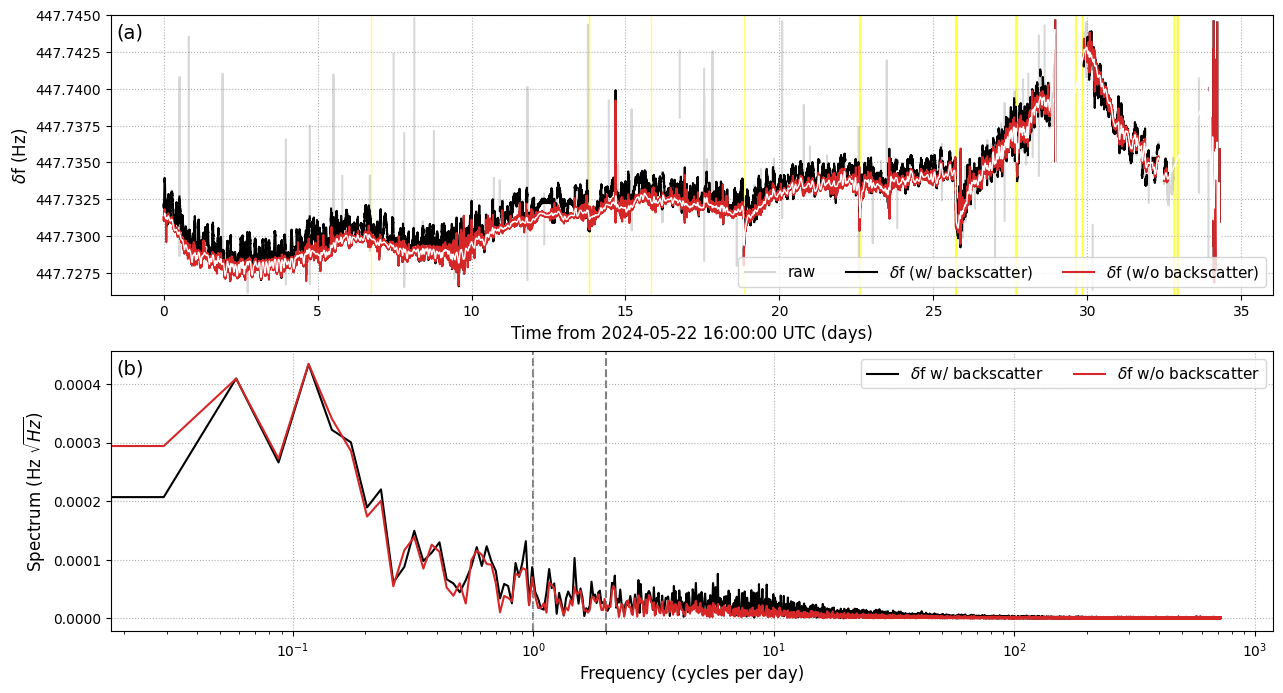

In [326]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1*86400, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2*86400, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")
    # ax[1].semilogx(f3, psd3, color="tab:grey", label=f"$\delta$f w/o backscatter (smooth)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=4, fontsize=font-1, ncol=3)
    ax[1].legend(loc=1, fontsize=font-1, ncol=3)

    ax[0].set_ylim(flim1, flim2)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC ({tunit})", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (cycles per day)", fontsize=font)

    ax[1].axvline(1/(12*3600)*86400, ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600)*86400, ls="--", color="grey", zorder=0)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_spectrum_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


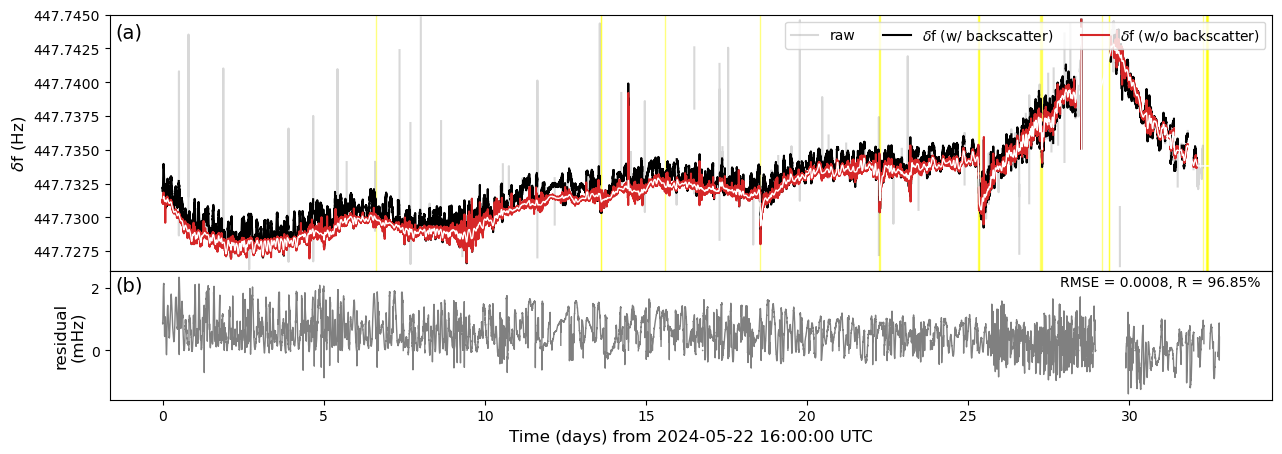

In [27]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    ax1.set_ylim(flim1, flim2)
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax2.set_ylabel(f"residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


## Plot with zoom-in

In [28]:
# %matplotlib tk

17280 19872


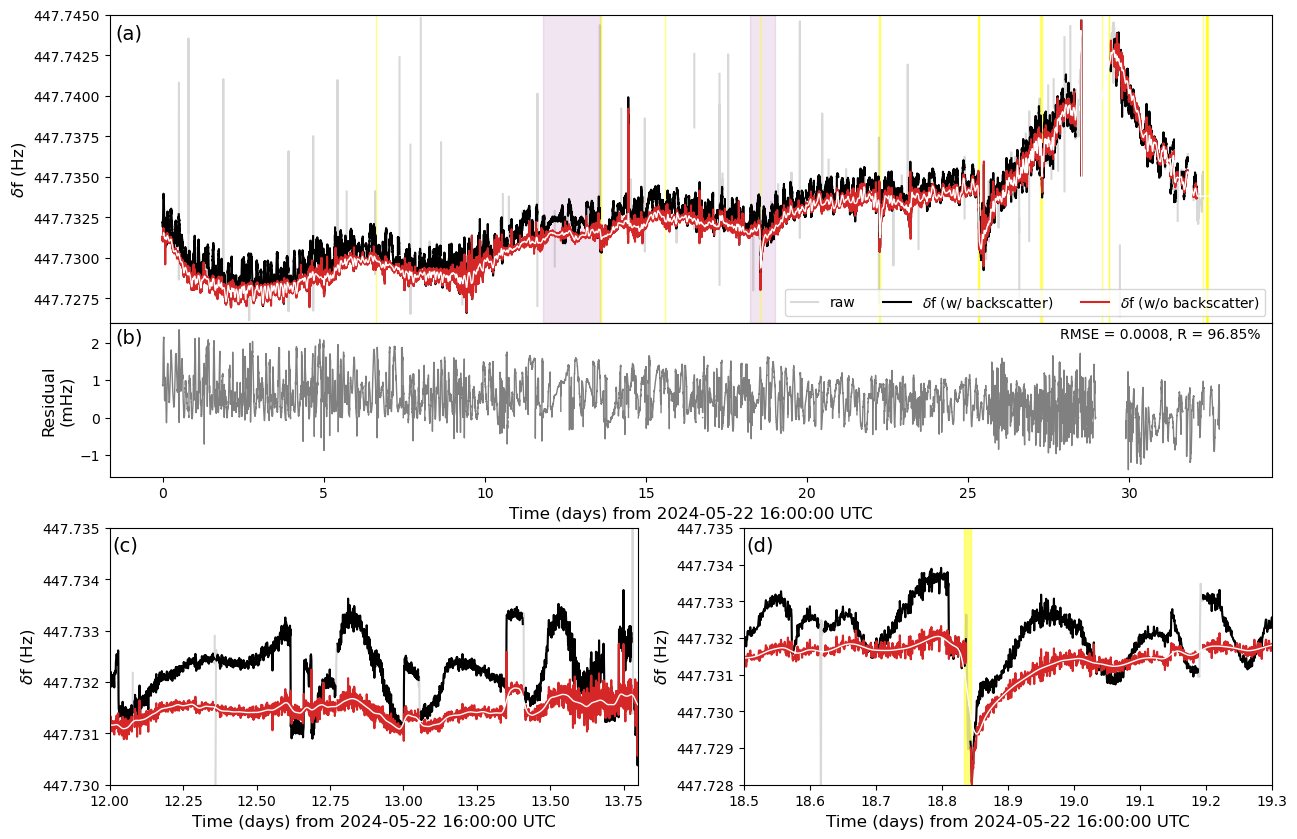

In [29]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 2, 5

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=1)

    ax1 = fig.add_subplot(gs1[0:2, :])
    ax2 = fig.add_subplot(gs1[2, :])
    ax3 = fig.add_subplot(gs2[3:5, :1])
    ax4 = fig.add_subplot(gs2[3:5, 1:])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    t31, t32 = 2.0, 2.7 # days
    t31, t32 = 12.0, 13.8 # days
    # t31, t32 = 8.0, 9.0 # days
    n31, n32 = int(t31*1440), int(t32*1440)
    print(n31, n32)
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs[n31:n32], color="tab:grey", alpha=0.3, label="raw")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs_nan[n31:n32], color="black", label=f"$\delta$f (w/ backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_nan[n31:n32], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_smooth[n31:n32], color="w", lw=1)
    ax3.set_xlim(t31, t32)

    t41 ,t42 = 18.5, 19.3 # days
    n41, n42 = int(t41*1440), int(t42*1440)
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs[n41:n42], color="tab:grey", alpha=0.3, label="raw")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs_nan[n41:n42], color="black", label=f"$\delta$f (w/ backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_nan[n41:n42], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_smooth[n41:n42], color="w", lw=1)
    ax4.set_xlim(t41, t42)


    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n31]*tscale, bs.time_sec[n32]*tscale,
                      color="purple", alpha=0.1
                     )
    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n41]*tscale, bs.time_sec[n42]*tscale,
                      color="purple", alpha=0.1
                     )

    ax1.set_ylim(flim1, flim2)
    ax3.set_ylim(447.730, 447.735)
    ax4.set_ylim(447.728, 447.735)

    for ax in [ax1, ax3, ax4]:
        ax.ticklabel_format(useOffset=False)
        ax.set_ylabel(f"$\delta$f (Hz)", fontsize=font)

    ax1.legend(loc=4, ncol=3)

    ax2.set_ylabel(f"Residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax3.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")


    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax3.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax4.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


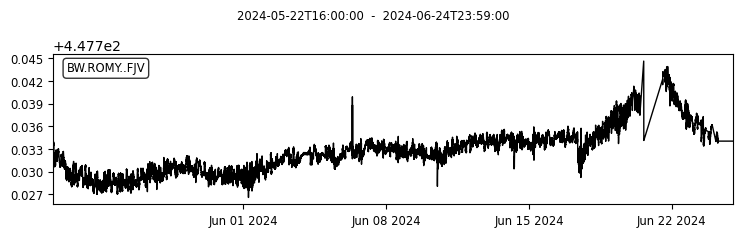

In [194]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_fs_inter)

rx = Trace()
rx.data = dff
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [337]:
t1, t2 = config['tbeg']+12.0298*86400, config['tbeg']+12.613*86400

In [338]:
_ps1 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", t1-3600, t2+3600)
_ps7 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", t1-3600, t2+3600)
_ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", t1-3600, t2+3600)

In [339]:
for _ps in [_ps1, _ps7, _ps9]:
    _ps.detrend("demean")
    _ps.decimate(10, no_filter=False)
    _ps.decimate(6, no_filter=False)



In [382]:
def __get_diff(arr):
    return round(arr[~np.isnan(arr)][-1] - arr[~np.isnan(arr)][0], 5)

In [391]:
# selected interval and surrounding
_rx0 = rx.copy()
rx0 = _rx0.trim(t1-3600, t2+3600)[0].data
trx0 = _rx0[0].times(reftime=t1)

_ps01 = _ps1.copy()
ps01 = _ps01[0].data
tps01 = _ps01[0].times(reftime=t1)

_ps07 = _ps7.copy()
ps07 = _ps07[0].data
tps07 = _ps07[0].times(reftime=t1)

_ps09 = _ps9.copy()
ps09 = _ps09[0].data
tps09 = _ps09[0].times(reftime=t1)

# selected interval
_rx1 = rx.copy()
rx1 = _rx1.trim(t1, t2)[0].data
trx1 = _rx1[0].times(reftime=t1)


_ps11 = _ps1.copy()
ps11 = _ps11.trim(t1, t2)[0].data
tps11 = _ps11[0].times(reftime=t1)

_ps17 = _ps7.copy()
ps17 = _ps17.trim(t1, t2)[0].data
tps17 = _ps17[0].times(reftime=t1)

_ps19 = _ps9.copy()
ps19 = _ps19.trim(t1, t2)[0].data
tps19 = _ps19[0].times(reftime=t1)

rn = 100
_reduce = np.nanmean(ps11[:rn])
ps11 -= _reduce
ps01 -= _reduce
_reduce = np.nanmean(ps17[:rn])
ps17 -= _reduce
ps07 -= _reduce
_reduce = np.nanmean(ps19[:rn])
ps19 -= _reduce
ps09 -= _reduce

rn = 10
_reduce = np.nanmean(rx1[:rn])
rx1 -= _reduce
rx0 -= _reduce

ps11_smooth = __smooth(ps01, 120)
ps17_smooth = __smooth(ps07, 120)
ps19_smooth = __smooth(ps09, 120)

rx1_smooth = __smooth(rx1, 180)
rx11_smooth = __smooth(rx0, 180)


print("ps11: ", __get_diff(ps11_smooth))
print("ps17: ", __get_diff(ps17_smooth))
print("ps19: ", __get_diff(ps19_smooth))

ps11:  -0.00126
ps17:  0.03788
ps19:  0.01375


In [371]:
_ps_diff = np.nanmean(ps11[-10:]) - np.nanmean(ps1[:10])
print(_ps_diff)

_rx_diff = np.nanmean(rx1[-10:]) - np.nanmean(rx1[:10])
print(_rx_diff)

-16.036640878807006
0.001517908402922785


In [372]:
alpha = 15e-6 # m/m/°C

strain = 633e-9 / 36

strain / alpha

0.0011722222222222223

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


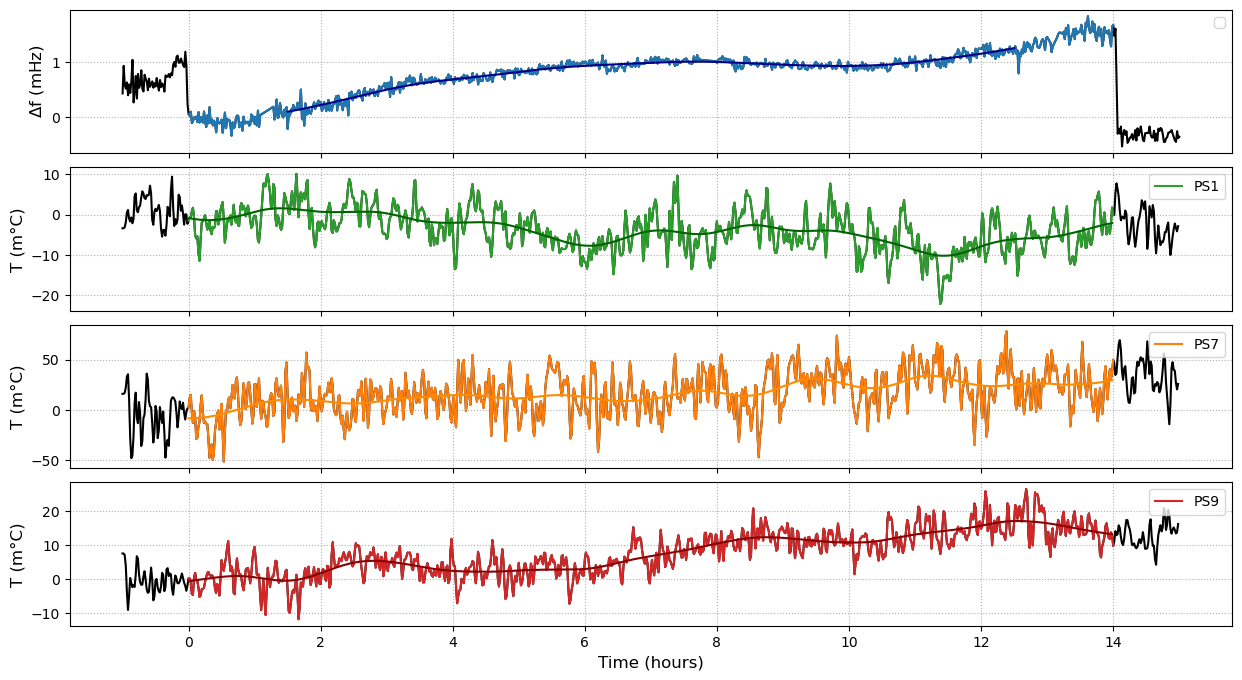

In [373]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/3600, "hours"
    Tscale, Tunit = 1e3, "m°C"
    fscale, funit = 1e3, "mHz"

    ax[0].plot(trx0*tscale, rx0*fscale, color="black")
    ax[0].plot(trx1*tscale, rx1*fscale, color="tab:blue")
    ax[0].plot(trx1*tscale, rx1_smooth*fscale, color="darkblue")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(tps01*tscale, ps01*Tscale, color="black")
    ax[1].plot(tps11*tscale, ps11*Tscale, color="tab:green", label="PS1")
    ax[1].plot(tps01*tscale, ps11_smooth*Tscale, color="darkgreen")

    ax[2].plot(tps07*tscale, ps07*Tscale, color="black")
    ax[2].plot(tps17*tscale, ps17*Tscale, color="tab:orange", label="PS7")
    ax[2].plot(tps07*tscale, ps17_smooth*Tscale, color="darkorange")

    ax[3].plot(tps09*tscale, ps09*Tscale, color="black")
    ax[3].plot(tps19*tscale, ps19*Tscale, color="tab:red", label="PS9")
    ax[3].plot(tps09*tscale, ps19_smooth*Tscale, color="darkred")

    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[2].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[3].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[3].set_xlabel(f"Time ({tunit})", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


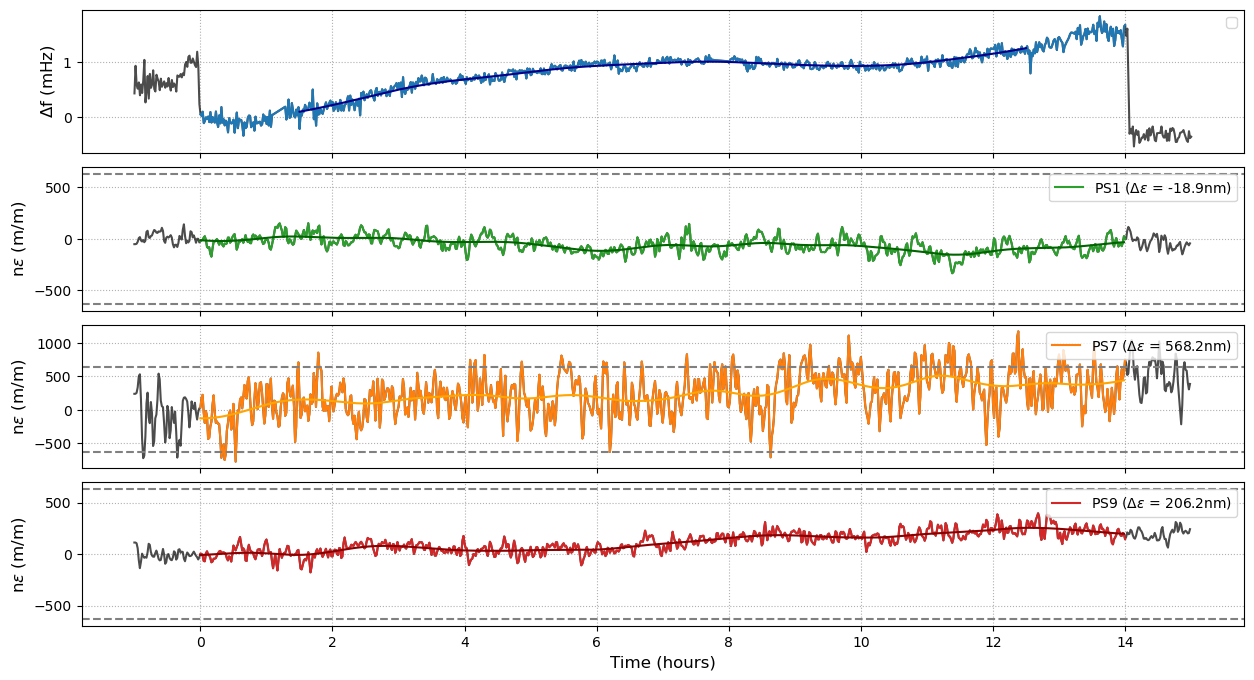

In [387]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/3600, "hours"
    Tscale, Tunit = 1, "m/m"
    fscale, funit = 1e3, "mHz"

    alpha = 15e-6 * 1e9

    ps11_diff = round(__get_diff(ps11_smooth*alpha), 1)
    ps17_diff = round(__get_diff(ps17_smooth*alpha), 1)
    ps19_diff = round(__get_diff(ps19_smooth*alpha), 1)

    ax[0].plot(trx0*tscale, rx0*fscale, color="black", alpha=0.7)
    ax[0].plot(trx1*tscale, rx1*fscale, color="tab:blue")
    ax[0].plot(trx1*tscale, rx1_smooth*fscale, color="darkblue")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(tps01*tscale, ps01*alpha, color="black", alpha=0.7)
    ax[1].plot(tps11*tscale, ps11*alpha, color="tab:green", label=f"PS1 ($\Delta\epsilon$ = {ps11_diff}nm)")
    ax[1].plot(tps01*tscale, ps11_smooth*alpha, color="darkgreen")

    ax[2].plot(tps07*tscale, ps07*alpha, color="black", alpha=0.7)
    ax[2].plot(tps17*tscale, ps17*alpha, color="tab:orange", label=f"PS7 ($\Delta\epsilon$ = {ps17_diff}nm)")
    ax[2].plot(tps07*tscale, ps17_smooth*alpha, color="orange")

    ax[3].plot(tps09*tscale, ps09*alpha, color="black", alpha=0.7)
    ax[3].plot(tps19*tscale, ps19*alpha, color="tab:red", label=f"PS9 ($\Delta\epsilon$ = {ps19_diff}nm)")
    ax[3].plot(tps09*tscale, ps19_smooth*alpha, color="darkred")

    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[2].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[3].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[3].set_xlabel(f"Time ({tunit})", fontsize=font)

    for _k in range(1, 4):
        ax[_k].axhline(633, color="grey", ls="--")
        ax[_k].axhline(-633, color="grey", ls="--")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();


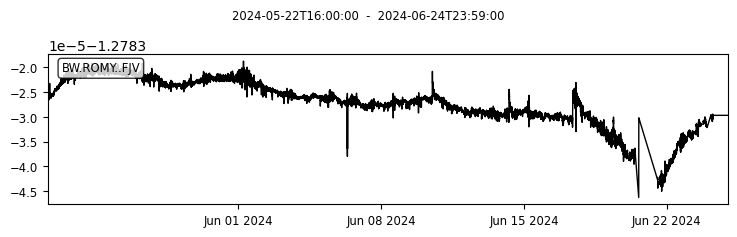

In [34]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_bs_inter)

dff_tilt = __sagnac_to_tilt(dff, config['ring'])

rx = Trace()
rx.data = dff_tilt
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

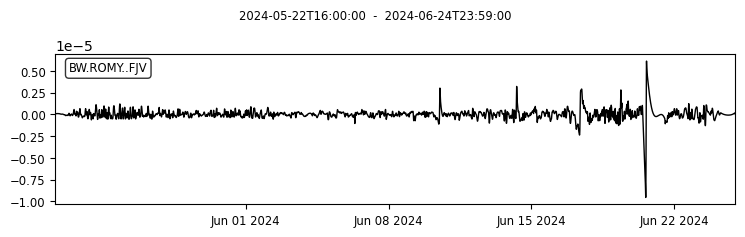

In [35]:
fmin, fmax = 1/(24*3600), 1/(1*3600)


rxx = rx.copy()

rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=False)
rxx = rxx.detrend("linear")

rxx = rxx.taper(0.05)

# rxx = rxx.filter("lowpass", freq=fmax, corners=2, zerophase=True)

rxx = rxx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

# rxx = rxx.resample(10*fmax, no_filter=True)
rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=True)

rxx

rxx.plot();